In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import astropy.units as u
%matplotlib inline
%config InlineBackend.figure_format = "retina"
from matplotlib import rcParams
rcParams['savefig.dpi'] = 550
rcParams['font.size'] = 20
plt.rc('font', family='serif')
import lsdb
from tqdm import tqdm
import dask
dask.config.set({"temporary-directory" :'/epyc/ssd/users/atzanida/tmp'})
dask.config.set({"dataframe.shuffle-compression": 'Snappy'})
from dask.distributed import Client

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'dataframe.shuffle-compression' has been deprecated; please use 'dataframe.shuffle.compression' instead
  warnings.warn(


In [6]:
 # magic for real time editing of .py files
%load_ext autoreload
%autoreload 2

# Custom functions and tools 
import sys
sys.path.insert(1, '../../dipper')

import tools as my_tools
import dipper as dip_pipeline
import models as dip_models
from evaluate import evaluate as evaluate
from gpmcmc import model_gp

## Catalogs

In [9]:
%%time
#Load ZTF, Gaia, and ZTF sources hipscats # note data3/ for epyc
gaia = lsdb.read_hipscat("/data3/epyc/data3/hipscat/catalogs/gaia_dr3/gaia", 
                        columns=['ra', 'dec', 'parallax', 'parallax_over_error', 
                                'bp_rp', 'solution_id', 
                                'source_id', 
                                'pmra', 'pmra_error', 
                                'pmdec', 'pmdec_error', 
                                'parallax_error', 
                                'phot_g_mean_mag', 
                                'l', 'b', 'non_single_star', 
                                'classprob_dsc_combmod_galaxy', 
                                'classprob_dsc_combmod_star', 
                                 'in_qso_candidates'])

# load ZTF object table
ztf = lsdb.read_hipscat("/epyc/data3/hipscat/catalogs/ztf_axs/ztf_dr14")

# Load ZTF DR14 sources
ztf_sources = lsdb.read_hipscat("/epyc/data3/hipscat/catalogs/ztf_axs/ztf_source")

CPU times: user 2min 10s, sys: 28.2 s, total: 2min 38s
Wall time: 2min 39s


In [13]:
e = ztf._ddf.head(2_000, npartitions=10)

In [20]:
M = np.zeros(shape=(2_000,2))
M[:,0] = e.ra.values
M[:, 1] = e.dec.values

In [22]:
np.save("ztf_pointings_test",M)

In [25]:
!ls

Aliasing Dippers in ZTF.ipynb
All Sky FGK Dwarf Search.ipynb
Full FG Dwarf Dipper Search Initial.ipynb
Light Curve Filtering and Fitting Validation.ipynb
MultiBand Dipper FG Search.ipynb
Selecting Main-Sequence Stars from StarHorse.ipynb
[Concept-1] Dip Detections FG Stars.ipynb
ztf_pointings_test.npy


In [8]:
%%time
star_horse = dask.dataframe.read_parquet("/epyc/ssd/users/atzanida/tmp/starH24/StarHorseFGK.parquet", engine='pyarrow')
star_horse = star_horse.compute()

CPU times: user 25.2 s, sys: 3min 10s, total: 3min 35s
Wall time: 31.8 s


In [35]:
print (f"Number of STARHORSE FGK stars: {len(star_horse)}")

Number of STARHORSE FGK stars: 106866623


Text(0, 0.5, 'Dec [deg]')

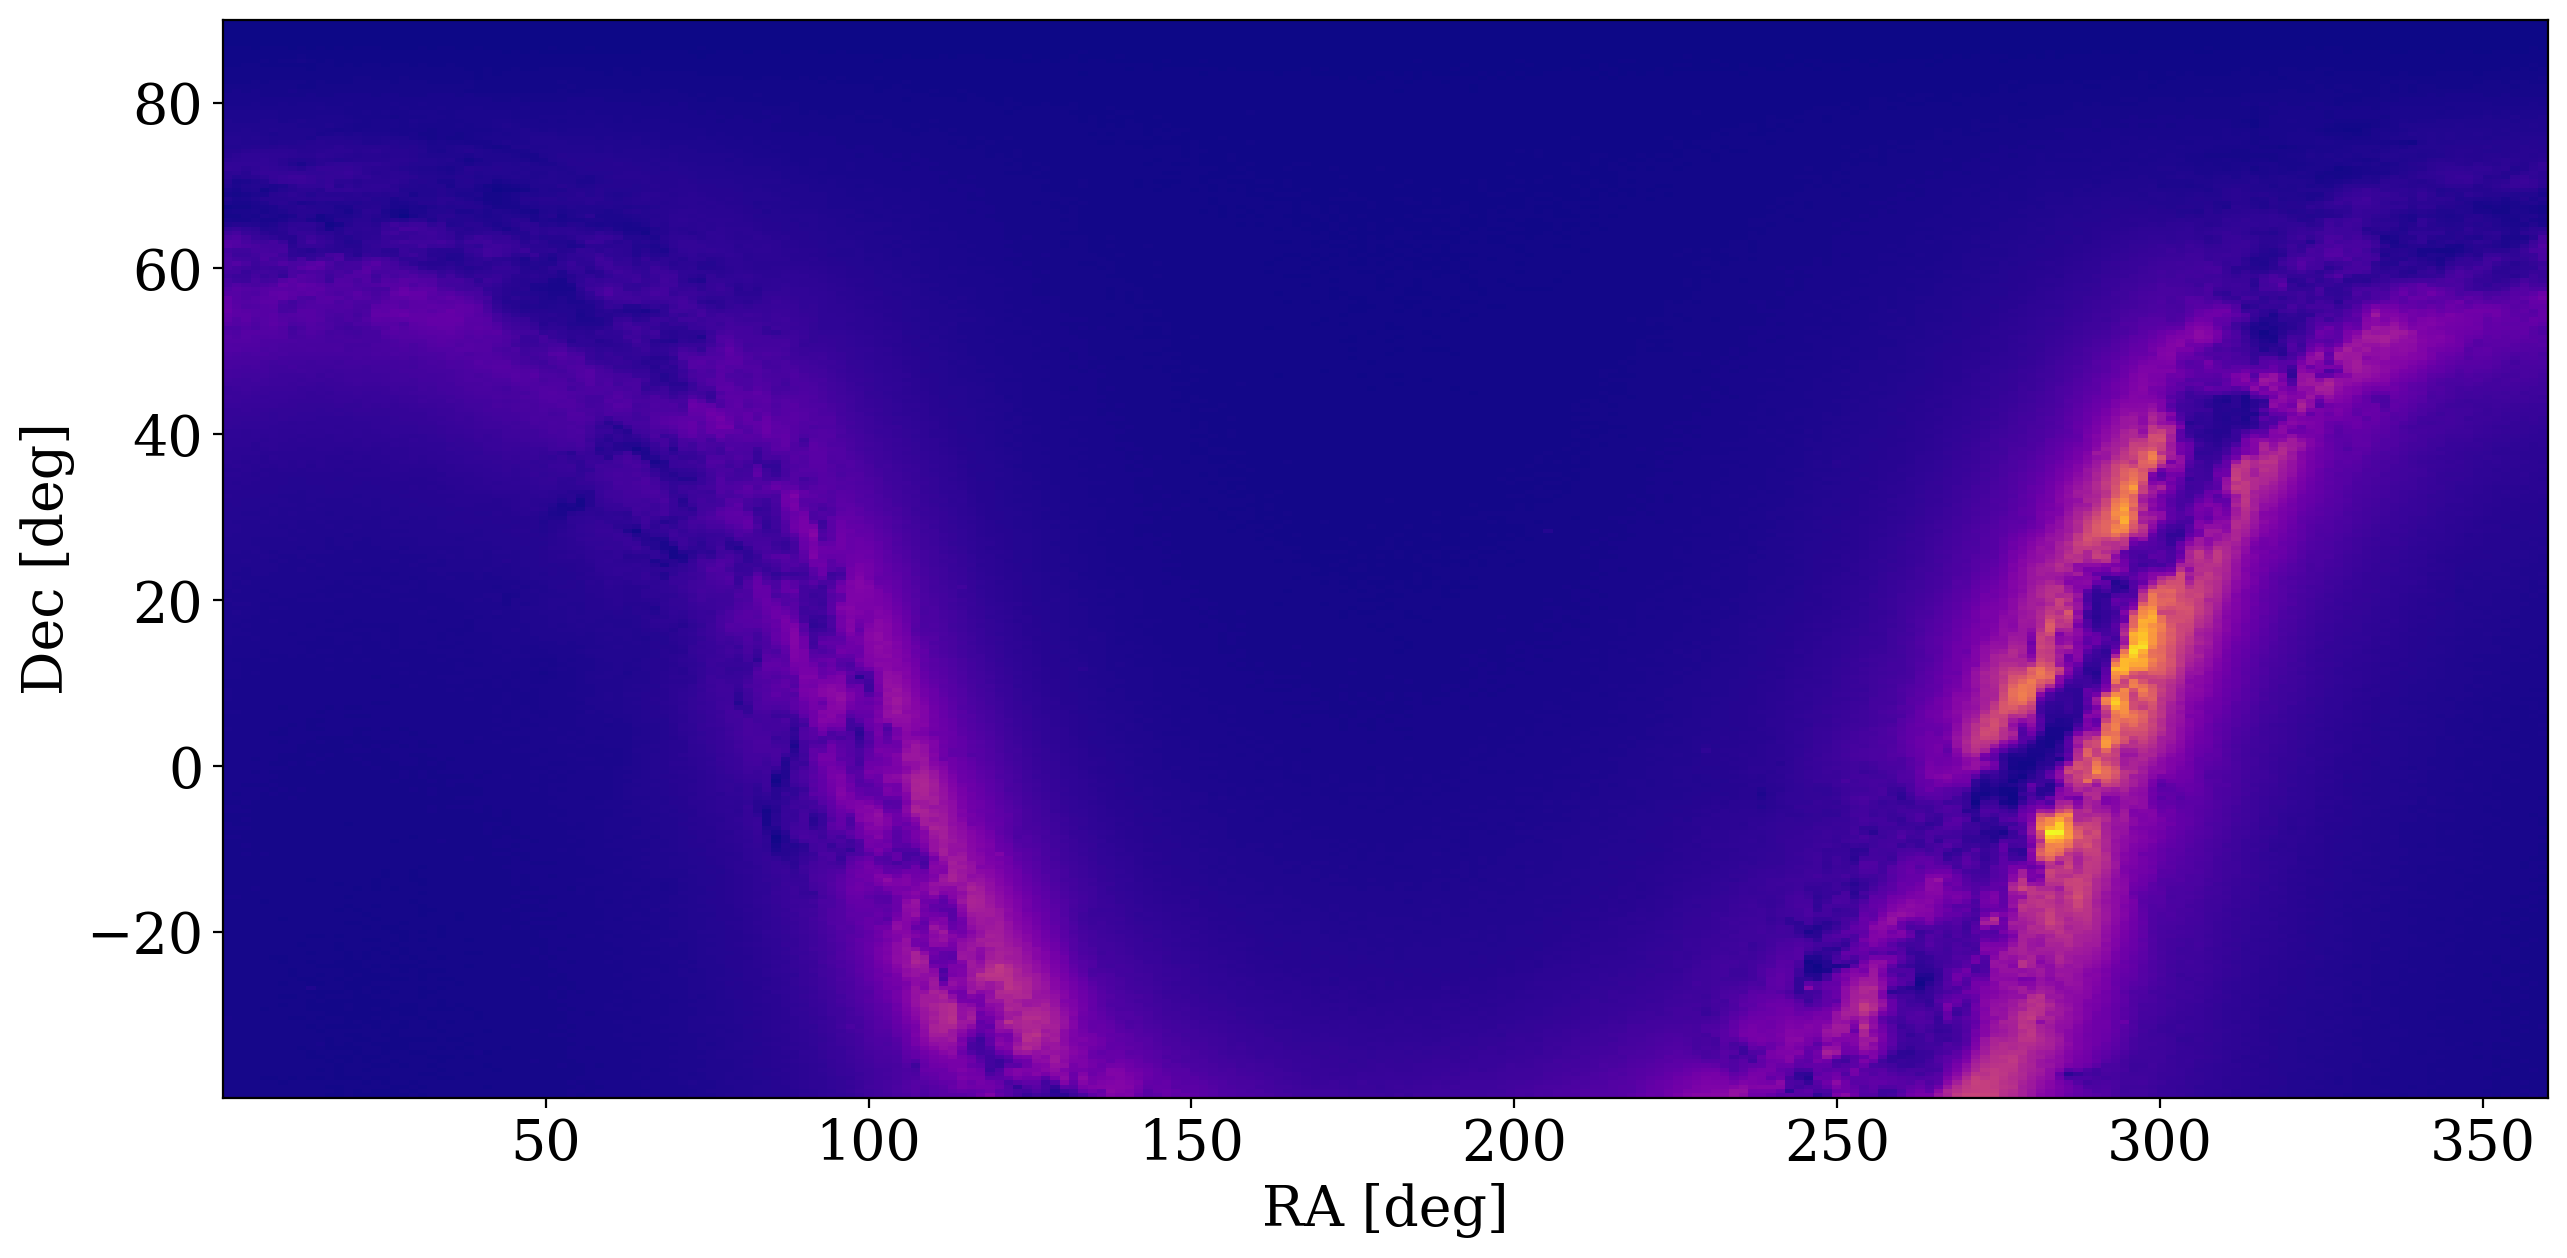

In [11]:
# let's visualize all sky coverage
plt.figure(figsize=(15,7))
_ = plt.hist2d(star_horse['RA_ICRS'],
               star_horse['DE_ICRS'], bins=(250, 250), cmap='plasma')
plt.xlabel("RA [deg]")
plt.ylabel("Dec [deg]")

In [13]:
%%time # started Feb 19 @ 2PM

# StarHorse into hipscat
star_horse_cat = lsdb.from_dataframe(
    star_horse,
    catalog_name="StarHorse",
    catalog_type="object",
    lowest_order=5, 
    highest_order=8, 
    ra_column="RA_ICRS", 
    dec_column="DE_ICRS", 
    threshold=1_000_000)

CPU times: user 47min 2s, sys: 11min 57s, total: 58min 59s
Wall time: 59min 3s


In [16]:
%%time
# Save it to disk in HiPSCat format
#star_horse_cat.to_hipscat("/nvme/users/atzanida/tmp/starhorse_hips")
# Stored on Feb. 19

CPU times: user 8min 9s, sys: 1min 58s, total: 10min 7s
Wall time: 4min 42s


In [7]:
%%time
star_horse_cat = lsdb.read_hipscat("/nvme/users/atzanida/tmp/starhorse_hips")

CPU times: user 2.29 s, sys: 130 ms, total: 2.41 s
Wall time: 2.69 s


In [8]:
%%time

# Crossmatch ZTF object to StarHorse Catalog
all_combo = star_horse_cat.crossmatch(ztf)

NameError: name 'ztf' is not defined

In [33]:
%%time
all_combo._ddf.head(5, npartitions=2)

CPU times: user 2.61 s, sys: 881 ms, total: 3.49 s
Wall time: 1.89 s


,Source_StarHorse,RA_ICRS_StarHorse,DE_ICRS_StarHorse,teff50_StarHorse,logg50_StarHorse,met50_StarHorse,dist50_StarHorse,fidelity_StarHorse,GMAG0_StarHorse,BP-RP0_StarHorse,...,nobs_g_ztf_dr14,nobs_r_ztf_dr14,nobs_i_ztf_dr14,mean_mag_g_ztf_dr14,mean_mag_r_ztf_dr14,mean_mag_i_ztf_dr14,Norder_ztf_dr14,Dir_ztf_dr14,Npix_ztf_dr14,_DIST
_hipscat_index,,,,,,,,,,,,,,,,,,,,,
12482248704,4295806720,44.996155,0.005615,5452.18,4.557970,-0.486325,2.280843,1.0,5.611737,0.896228,...,364,381,18,18.143208,17.569102,17.373423,3,0,0,0.000011
116614234112,38655544960,45.004978,0.019880,4933.98,4.638439,-0.309177,0.312808,1.0,6.318658,1.120751,...,371,387,18,14.916993,14.028394,13.727368,3,0,0,0.000034
751493447680,343597448960,44.963896,0.043595,5167.75,4.535853,-0.165656,2.486011,1.0,5.718467,1.044423,...,359,379,17,18.873053,18.022047,17.742535,3,0,0,0.000019
1131799379968,549755818112,45.048282,0.048254,5411.06,4.525750,-0.147021,0.603629,1.0,5.369191,0.885475,...,381,391,18,15.716422,14.905342,14.602479,3,0,0,0.000014
1702816120832,828929527040,45.023620,0.068419,4754.50,4.653356,-0.437974,0.786489,1.0,6.655048,1.194384,...,380,393,18,17.505628,16.473952,16.109312,3,0,0,0.000007


In [34]:
%%time # ran at 1:14PM 
all_combo._ddf.shape[0].compute() # number of FGK dwafs in ZTF footprint

CPU times: user 2h 18min 22s, sys: 2h 12min 1s, total: 4h 30min 23s
Wall time: 19min 39s


89753137

## Make a CMD of FGK Dwarfs

/tmp/ipykernel_120484/1060391087.py:10: RuntimeWarning: divide by zero encountered in log10
  J_log = np.log10(J)


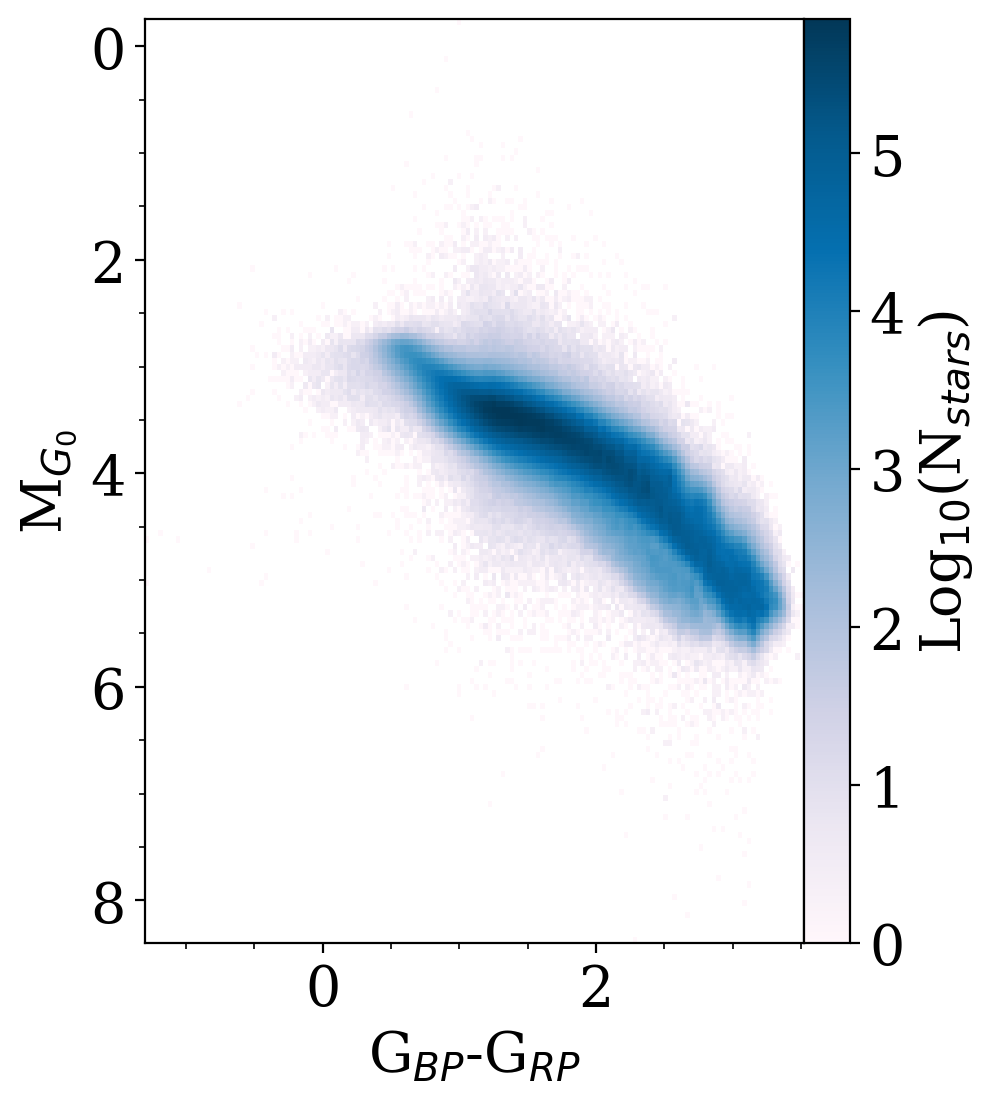

In [67]:
# Create a mask for NaN values
mask = ~np.isnan(star_horse['BP-RP0']) & ~np.isnan(star_horse['GMAG0'])

# Use the mask to select only non-NaN values
J, xedges, yedges = np.histogram2d(star_horse['BP-RP0'][mask],
                                   star_horse['GMAG0'][mask], 
                                   bins=(150, 150))

J_log = np.log10(J)

plt.figure(figsize=(5, 6))
# Plot the log-scaled imshow
plt.imshow(J_log,
           extent=[xedges[0],
                   xedges[-1],
                   yedges[0], 
                   yedges[-1]], 
           aspect='auto', origin='lower', cmap='PuBu')

plt.xlabel("G$_{BP}$-G$_{RP}$")
plt.ylabel("M$_{G_0}$")
plt.ylim(plt.ylim()[::-1])
plt.colorbar(pad=0.00001, label='Log$_{10}$(N$_{stars}$)')
plt.minorticks_on()

## Initialize TAPE

In [68]:
import dask.dataframe as dd
from tape import Ensemble, ColumnMapper
pd.options.mode.chained_assignment = None

# Initialize an Ensemble
ens = Ensemble(n_workers=15, threads_per_worker=1)
ens.client_info()

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37232 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:37232/status,
Dashboard: http://127.0.0.1:37232/status,Workers: 15
Total threads: 15,Total memory: 0.98 TiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44801,Workers: 15
Dashboard: http://127.0.0.1:37232/status,Total threads: 15
Started: Just now,Total memory: 0.98 TiB
Comm: tcp://127.0.0.1:35351,Total threads: 1
Dashboard: http://127.0.0.1:37325/status,Memory: 67.17 GiB
Nanny: tcp://127.0.0.1:39443,


In [103]:
%%time
_sources = all_combo.join(
    ztf_sources, left_on="ps1_objid_ztf_dr14", right_on="ps1_objid")

CPU times: user 2min 37s, sys: 7.38 s, total: 2min 44s
Wall time: 2min 44s


In [2]:
print (True)

True


In [209]:
%%time
dm = all_combo._ddf.head(70_050, npartitions=68)

CPU times: user 1min 2s, sys: 1min 29s, total: 2min 31s
Wall time: 8.14 s


In [211]:
qr = (dm['ps1_gMeanPSFMag_ztf_dr14'] > -999) & \
        (dm['ps1_rMeanPSFMag_ztf_dr14'] > -999) & \
(dm['ps1_iMeanPSFMag_ztf_dr14'] > -999) & \
(dm['ps1_gMeanPSFMag_ztf_dr14']!=np.nan) & \
(dm['ps1_rMeanPSFMag_ztf_dr14']!=np.nan) & \
(dm['ps1_iMeanPSFMag_ztf_dr14']!=np.nan) 

In [212]:
ff2 = dm[qr]

gr = ff2['ps1_gMeanPSFMag_ztf_dr14']-ff2['ps1_rMeanPSFMag_ztf_dr14']
ri = ff2['ps1_rMeanPSFMag_ztf_dr14']-ff2['ps1_iMeanPSFMag_ztf_dr14']

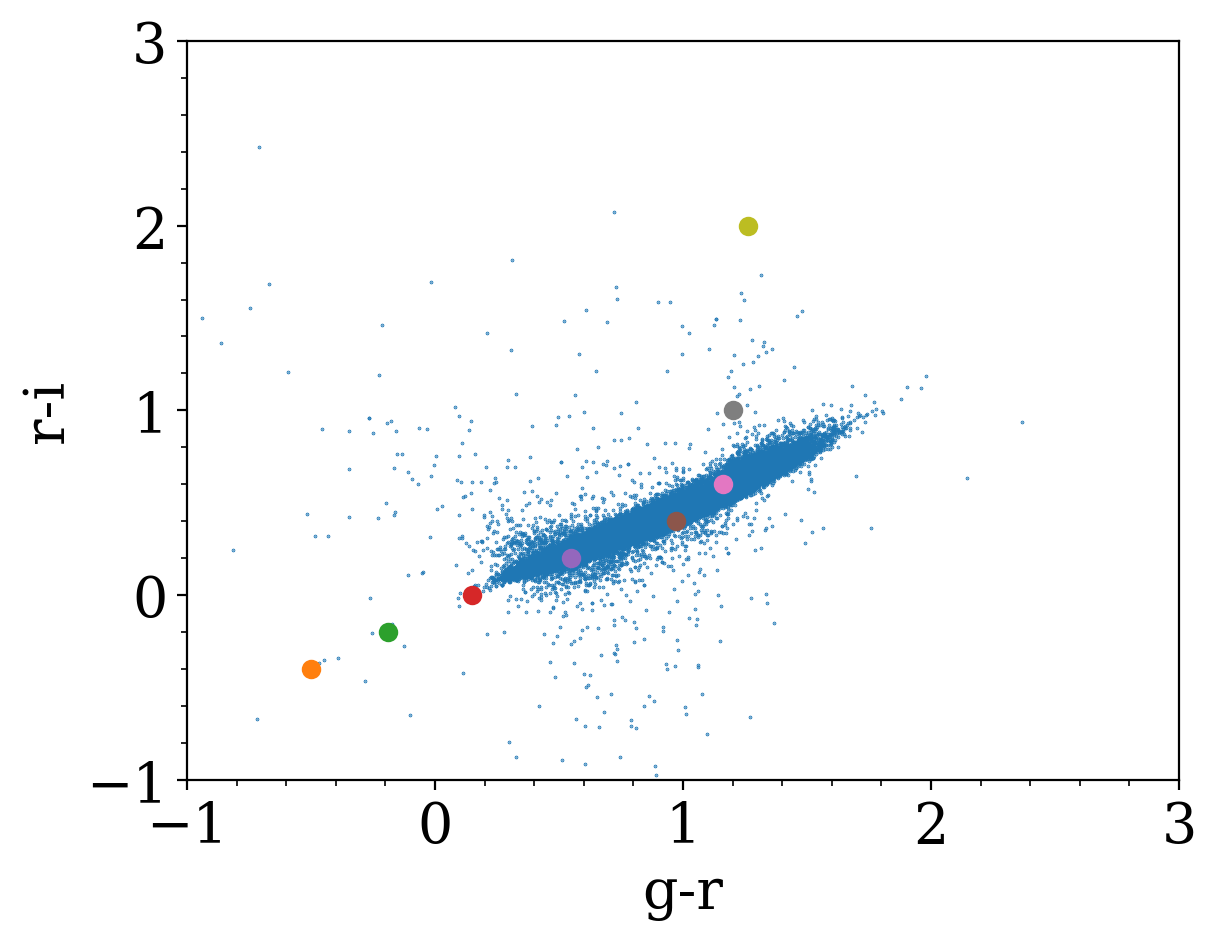

In [251]:
plt.scatter(gr, ri, s=0.1)
plt.xlim(-1, 3)
plt.ylim(-1, 3)

plt.minorticks_on()
plt.xlabel("g-r")
plt.ylabel("r-i")

# stellar locus from https://iopscience.iop.org/article/10.1088/0004-637X/750/2/99
plt.scatter(-0.50, -0.4)
plt.scatter(-0.19, -0.2)
plt.scatter(0.15, 0)
plt.scatter(0.55, 0.2)
plt.scatter(0.97, 0.4)
plt.scatter(1.16, 0.6)
plt.scatter(1.2, 1)
plt.scatter(1.26, 2)


In [226]:
kk, xe, ye = np.histogram2d(gr, ri, bins=(250, 250))

/tmp/ipykernel_120484/2300308366.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(kk.T),


(0.0, 1.5)

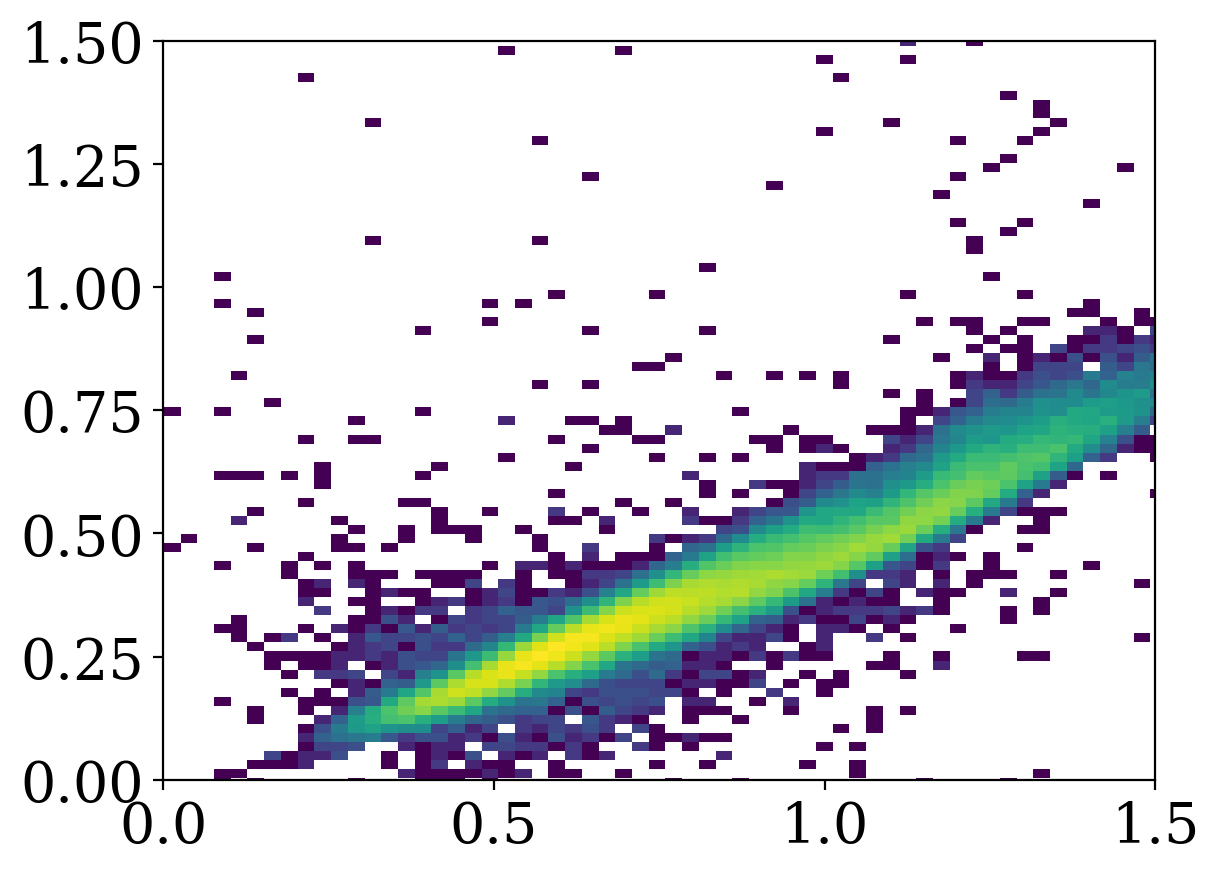

In [227]:
plt.imshow(np.log10(kk.T), 
          origin='lower', 
          extent=[min(gr), max(gr), min(ri), max(ri)], 
          aspect='auto')
plt.xlim(0, 1.5)
plt.ylim(0, 1.5)

In [252]:
dm.keys()

Index(['Source_StarHorse', 'RA_ICRS_StarHorse', 'DE_ICRS_StarHorse',
       'teff50_StarHorse', 'logg50_StarHorse', 'met50_StarHorse',
       'dist50_StarHorse', 'fidelity_StarHorse', 'GMAG0_StarHorse',
       'BP-RP0_StarHorse', 'Norder_StarHorse', 'Dir_StarHorse',
       'Npix_StarHorse', 'ps1_objid_ztf_dr14', 'ra_ztf_dr14', 'dec_ztf_dr14',
       'ps1_gMeanPSFMag_ztf_dr14', 'ps1_rMeanPSFMag_ztf_dr14',
       'ps1_iMeanPSFMag_ztf_dr14', 'nobs_g_ztf_dr14', 'nobs_r_ztf_dr14',
       'nobs_i_ztf_dr14', 'mean_mag_g_ztf_dr14', 'mean_mag_r_ztf_dr14',
       'mean_mag_i_ztf_dr14', 'Norder_ztf_dr14', 'Dir_ztf_dr14',
       'Npix_ztf_dr14', '_DIST'],
      dtype='object')